## Basic Intro to Quantum ML

- The idea is to explore the potential applications of quantum computing in machine learning

### Model

- We'll be looking at using a QCNN (Quantum CNN) for classifying MNIST images. This is a fairly simple dataset, which makes it perfect for to test the efficacy of the Quantum Algorithm. In order to compare the model's performance, we will compare it to [LeNet-5]("http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf"). This model was released in 1998 by Yann LeCun. It was one of the earliest convnets used for image recognition, so it seems reasonable to consider it as a baseline for comparison to the QCNN, which is still in its infancy. `[we can't do this comparison yet]`

- Additionally, we will comapre both a Quantum and Classical Autoencoder


In [29]:
# imports

import torch
import torch.nn as nn
import torch.optim as optim  # used for optimization libraries (SGD, Adam, etc)
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm  # used for progress bars
import matplotlib.pyplot as plt

torch.manual_seed(17)  # computers a (pseudo) random, so specifying a seed allows for reproducibility
None

## Initial Steps (for classical models)

- Define hyperparams and util functions
- Create models
- Create dataloaders
- Train models


In [30]:
# Hyperparameters
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 1e-3
nb_channels = 16
embedding_dim = 8
batch_size = 64
nb_epochs = 25

In [114]:
# Utils
def plot_imgs(input, output):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(input, cmap="gray")
    ax[0].set_title("Input")
    ax[1].imshow(output, cmap="gray")
    ax[1].set_title("Output")
    plt.show()


def get_encoded_decoded(model, input):
    z = model.encode(input)
    output = model.decode(z)
    return z, output


def train_autoencoder(model, train_loader, optimizer, nb_epochs):
    for epoch in range(nb_epochs):
        acc_loss = 0
        for batch_idx, data in enumerate(tqdm(train_loader)):
            # send the data to cuda, if possible
            data = data.to(DEVICE)
            output = model(data)
            loss = 0.5 * (output - data).pow(2).sum() / data.size(0)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {acc_loss:.4f}")

In [32]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=6,
            kernel_size=(5, 5),
            stride=(1, 1),
            padding=(0, 0),
        )
        self.conv2 = nn.Conv2d(
            in_channels=6,
            out_channels=16,
            kernel_size=(5, 5),
            stride=(1, 1),
            padding=(0, 0),
        )
        self.conv3 = nn.Conv2d(
            in_channels=16,
            out_channels=120,
            kernel_size=(5, 5),
            stride=(1, 1),
            padding=(0, 0),
        )
        self.linear1 = nn.Linear(120, 84)
        self.linear2 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = x.reshape(x.shape[0], -1)
        x = self.relu(self.linear1(x))
        x = self.linear2(x)

        return x

In [33]:
# we need to reduce the size of the image, so instead of cropping we can use an autoencoder ro reduce the dimensionality
# note: PCA is a linear autoencoder


class ChannelAttention(nn.Module):
    def __init__(self, in_channels: int, reduction: int = 16) -> None:
        super().__init__()

        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if len(x.size()) == 3:
            b, c, _ = x.size()
        else:
            b, c, _, _ = x.size()
        avg_pool = self.avg_pool(x).view(b, c)
        max_pool = self.max_pool(x).view(b, c)
        return self.sigmoid(self.fc(avg_pool) + self.fc(max_pool)).view(b, c, 1, 1)


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size: int = 7) -> None:
        super().__init__()

        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        avg_pool = torch.mean(x, dim=1, keepdim=True)
        max_pool, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_pool, max_pool], dim=1)
        return self.sigmoid(self.conv(x))


class CBAM(nn.Module):
    def __init__(self, in_channels: int, reduction: int = 16) -> None:
        super().__init__()

        self.channel_attn = ChannelAttention(in_channels, reduction)
        self.spatial_attn = SpatialAttention()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.channel_attn(x) * x
        x = self.spatial_attn(x) * x
        return x


# CBAM paper - https://arxiv.org/abs/1807.06521
# CBAM is a module that uses both channel and spatial attention to improve the performance of a model


class AutoEncoder(nn.Module):
    def __init__(self, nb_channels: int, embedding_dim: int):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, nb_channels, kernel_size=5),  # to 24x24 - we are using MNIST
            nn.GELU(),
            nn.Conv2d(nb_channels, nb_channels, kernel_size=5),  # to 20x20
            nn.GELU(),
            nn.Conv2d(nb_channels, nb_channels, kernel_size=4, stride=2),  # to 9x9
            nn.GELU(),
            nn.Conv2d(nb_channels, nb_channels, kernel_size=3, stride=2),  # to 4x4
            nn.GELU(),
            nn.Conv2d(nb_channels, embedding_dim, kernel_size=4),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(embedding_dim, nb_channels, kernel_size=4),
            nn.GELU(),
            nn.ConvTranspose2d(nb_channels, nb_channels, kernel_size=3, stride=2),  # from 4x4
            nn.GELU(),
            nn.ConvTranspose2d(nb_channels, nb_channels, kernel_size=4, stride=2),  # from 9x9
            nn.GELU(),
            nn.ConvTranspose2d(nb_channels, nb_channels, kernel_size=5),  # from 20x20
            nn.GELU(),
            nn.ConvTranspose2d(nb_channels, 1, kernel_size=5),  # from 24x24
        )

        # print the number of parameters
        print(f"number of parameters: {(sum(p.numel() for p in self.parameters())):,}")

    def encode(self, x):
        return self.encoder(x).view(x.size(0), -1)

    def decode(self, z):
        return self.decoder(z.view(z.size(0), -1, 1, 1))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


"""
Why put the CBAM module directly after the conv layer?
  - well, from theory, we see that the typical conv-batchnorm-relu is a good combination so it makes sense to put the CBAM module after the conv layer.
    this block (conv-batchnorm-relu) make sense, because relu clips the values so you are essnetially losing some info. we would ideally want to learn
    what to pay "attention" to before we clip the values. that said, we're also swapping relu for gelu because it has been shown to perform better (it does in this). 
"""


class AutoEncoderCBAM(nn.Module):
    def __init__(self, nb_channels: int, embedding_dim: int):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, nb_channels, kernel_size=5),  # to 24x24 - we are using MNIST
            CBAM(nb_channels, 1),
            nn.GELU(),
            nn.Conv2d(nb_channels, nb_channels, kernel_size=5),  # to 20x20
            CBAM(nb_channels, 1),
            nn.GELU(),
            nn.Conv2d(nb_channels, nb_channels, kernel_size=4, stride=2),  # to 9x9
            CBAM(nb_channels, 1),
            nn.GELU(),
            nn.Conv2d(nb_channels, nb_channels, kernel_size=3, stride=2),  # to 4x4
            CBAM(nb_channels, 1),
            nn.GELU(),
            nn.Conv2d(nb_channels, embedding_dim, kernel_size=4),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(embedding_dim, nb_channels, kernel_size=4),
            CBAM(nb_channels, 1),
            nn.GELU(),
            nn.ConvTranspose2d(nb_channels, nb_channels, kernel_size=3, stride=2),  # from 4x4
            CBAM(nb_channels, 1),
            nn.GELU(),
            nn.ConvTranspose2d(nb_channels, nb_channels, kernel_size=4, stride=2),  # from 9x9
            CBAM(nb_channels, 1),
            nn.GELU(),
            nn.ConvTranspose2d(nb_channels, nb_channels, kernel_size=5),  # from 20x20
            CBAM(nb_channels, 1),
            nn.GELU(),
            nn.ConvTranspose2d(nb_channels, 1, kernel_size=5),  # from 24x24
        )

        # print the number of parameters
        print(f"number of parameters: {(sum(p.numel() for p in self.parameters())):,}")

    def encode(self, x):
        return self.encoder(x).view(x.size(0), -1)

    def decode(self, z):
        return self.decoder(z.view(z.size(0), -1, 1, 1))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [34]:
ae_train_set = datasets.MNIST("data/mnist/", train=True, download=True)
ae_train_dataset = ae_train_set.data.view(-1, 1, 28, 28).float()
mu, std = ae_train_dataset.mean(), ae_train_dataset.std()
ae_train_dataset.sub_(mu).div_(std)
ae_train_loader = DataLoader(dataset=ae_train_dataset, batch_size=batch_size, shuffle=True)

ae_test_set = datasets.MNIST("data/mnist/", train=False, download=True)
ae_test_dataset = ae_test_set.data.view(-1, 1, 28, 28).float()
ae_test_dataset.sub_(mu).div_(std)
None  # prevent it from printing the last line

In [35]:
autoencoder = AutoEncoder(nb_channels=nb_channels, embedding_dim=embedding_dim)
autoencoder = autoencoder.to(DEVICE)

number of parameters: 30,633


In [36]:
autoencoder_cbam = AutoEncoderCBAM(nb_channels=nb_channels, embedding_dim=embedding_dim)
autoencoder_cbam = autoencoder_cbam.to(DEVICE)

number of parameters: 35,513


In [107]:
get_optimizer = lambda model: optim.AdamW(model.parameters(), lr=learning_rate)
ae_optimizer = get_optimizer(autoencoder)
cbam_ae_optimizer = get_optimizer(autoencoder_cbam)

In [ ]:
train_autoencoder(autoencoder, ae_train_loader, ae_optimizer, nb_epochs)

In [ ]:
train_autoencoder(autoencoder_cbam, ae_train_loader, cbam_ae_optimizer, nb_epochs)

In [ ]:
input = ae_test_dataset[56].to(DEVICE)

# Encode / decode
z, output = get_encoded_decoded(autoencoder, input)
z_cbam, output_cbam = get_encoded_decoded(autoencoder_cbam, input.unsqueeze(0))

In [ ]:
plot_imgs(input.cpu().detach().numpy().squeeze(), output.cpu().detach().numpy().squeeze())

In [ ]:
plot_imgs(input.cpu().detach().numpy().squeeze(), output_cbam.cpu().detach().numpy().squeeze())

## Quantum Models


### QCNN


In [ ]:
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

algorithm_globals.random_seed = 17

In [ ]:
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl", style="clifford")

In [ ]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl", style="clifford")

In [ ]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl", style="clifford")

In [ ]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl", style="clifford")

In [ ]:
# Takes too long to train QCNN

# qcnn_train_set = datasets.MNIST("data/mnist/", train=True, transform=transforms.ToTensor(), download=True)
# qcnn_test_set = datasets.MNIST("data/mnist/", train=False, transform=transforms.ToTensor(), download=True)

# X_train, X_test, y_train, y_test = (
#     qcnn_train_set.data,
#     qcnn_test_set.data,
#     qcnn_train_set.targets,
#     qcnn_test_set.targets,
# )

# X_train = X_train.unsqueeze(1).reshape(-1, 1, 28, 28).to(torch.float32)
# X_test = X_test.unsqueeze(1).reshape(-1, 1, 28, 28).to(torch.float32)

# X_train_encoded = autoencoder.encode(X_train.to(DEVICE)).detach().cpu().numpy()
# X_test_encoded = autoencoder.encode(X_test.to(DEVICE)).detach().cpu().numpy()
# y_train = y_train.numpy()
# y_test = y_test.numpy()

# X_train_encoded = np.concatenate(
#     (X_train_encoded[np.where(y_train == 3)[0]], X_train_encoded[np.where(y_train == 6)[0]])
# )
# y_train = np.concatenate((y_train[np.where(y_train == 3)[0]], y_train[np.where(y_train == 6)[0]]))

# X_test_encoded = np.concatenate((X_test_encoded[np.where(y_test == 3)[0]], X_test_encoded[np.where(y_test == 6)[0]]))
# y_test = np.concatenate((y_test[np.where(y_test == 3)[0]], y_test[np.where(y_test == 6)[0]]))

# X_train_encoded, y_train = shuffle(X_train_encoded, y_train, random_state=17)
# X_test_encoded, y_test = shuffle(X_test_encoded, y_test, random_state=17)

# # labels/targets need to be 1 and -1
# y_train[y_train == 3] = -1
# y_train[y_train == 6] = 1
# y_test[y_test == 3] = -1
# y_test[y_test == 6] = 1

In [ ]:
def generate_dataset(num_images):
    images = []
    labels = []
    hor_array = np.zeros((6, 8))
    ver_array = np.zeros((4, 8))

    j = 0
    for i in range(0, 7):
        if i != 3:
            hor_array[j][i] = np.pi / 2
            hor_array[j][i + 1] = np.pi / 2
            j += 1

    j = 0
    for i in range(0, 4):
        ver_array[j][i] = np.pi / 2
        ver_array[j][i + 4] = np.pi / 2
        j += 1

    for n in range(num_images):
        rng = algorithm_globals.random.integers(0, 2)
        if rng == 0:
            labels.append(-1)
            random_image = algorithm_globals.random.integers(0, 6)
            images.append(np.array(hor_array[random_image]))
        elif rng == 1:
            labels.append(1)
            random_image = algorithm_globals.random.integers(0, 4)
            images.append(np.array(ver_array[random_image]))

        # Create noise
        for i in range(8):
            if images[-1][i] == 0:
                images[-1][i] = algorithm_globals.random.uniform(0, np.pi / 4)
    return images, labels

In [ ]:
images, labels = generate_dataset(100)

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.3, random_state=17)

In [ ]:
feature_map = ZFeatureMap(8)

ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "c1"), list(range(8)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

In [ ]:
circuit.draw("mpl", style="clifford")

In [ ]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [ ]:
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=200),  # Set max iterations here
    callback=callback_graph,
)

In [ ]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
# classifier.fit(X_train_encoded, y_train)

x = np.asarray(train_images)
y = np.asarray(train_labels)
classifier.fit(x, y)

In [ ]:
x = np.asarray(test_images)
y = np.asarray(test_labels)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")

### Quantum Autoencoder


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import Statevector
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals

from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.neural_networks import SamplerQNN

algorithm_globals.random_seed = 17

In [2]:
def ansatz(num_qubits):
    return RealAmplitudes(num_qubits, reps=5)

In [3]:
def auto_encoder_circuit(num_latent, num_trash):
    qr = QuantumRegister(num_latent + 2 * num_trash + 1, "q")
    cr = ClassicalRegister(1, "c")
    circuit = QuantumCircuit(qr, cr)
    circuit.compose(ansatz(num_latent + num_trash), range(0, num_latent + num_trash), inplace=True)
    circuit.barrier()
    auxiliary_qubit = num_latent + 2 * num_trash
    # swap test
    circuit.h(auxiliary_qubit)
    for i in range(num_trash):
        circuit.cswap(auxiliary_qubit, num_latent + i, num_latent + num_trash + i)

    circuit.h(auxiliary_qubit)
    circuit.measure(auxiliary_qubit, cr[0])
    return circuit

In [ ]:
def zero_idx(j, i):
    # Index for zero pixels
    return [
        [i, j],
        [i - 1, j - 1],
        [i - 1, j + 1],
        [i - 2, j - 1],
        [i - 2, j + 1],
        [i - 3, j - 1],
        [i - 3, j + 1],
        [i - 4, j - 1],
        [i - 4, j + 1],
        [i - 5, j],
    ]


def one_idx(i, j):
    # Index for one pixels
    return [[i, j - 1], [i, j - 2], [i, j - 3], [i, j - 4], [i, j - 5], [i - 1, j - 4], [i, j]]


def get_dataset_digits(num, draw=True):
    # Create Dataset containing zero and one
    train_images = []
    train_labels = []
    for i in range(int(num / 2)):
        # First we introduce background noise
        empty = np.array([algorithm_globals.random.uniform(0, 0.1) for i in range(32)]).reshape(8, 4)

        # Now we insert the pixels for the one
        for i, j in one_idx(2, 6):
            empty[j][i] = algorithm_globals.random.uniform(0.9, 1)
        train_images.append(empty)
        train_labels.append(1)
        if draw:
            plt.title("This is a One")
            plt.imshow(train_images[-1])
            plt.show()

    for i in range(int(num / 2)):
        empty = np.array([algorithm_globals.random.uniform(0, 0.1) for i in range(32)]).reshape(8, 4)

        # Now we insert the pixels for the zero
        for k, j in zero_idx(2, 6):
            empty[k][j] = algorithm_globals.random.uniform(0.9, 1)

        train_images.append(empty)
        train_labels.append(0)
        if draw:
            plt.imshow(train_images[-1])
            plt.title("This is a Zero")
            plt.show()

    train_images = np.array(train_images)
    train_images = train_images.reshape(len(train_images), 32)

    for i in range(len(train_images)):
        sum_sq = np.sum(train_images[i] ** 2)
        train_images[i] = train_images[i] / np.sqrt(sum_sq)

    return train_images, train_labels


train_images, __ = get_dataset_digits(10)

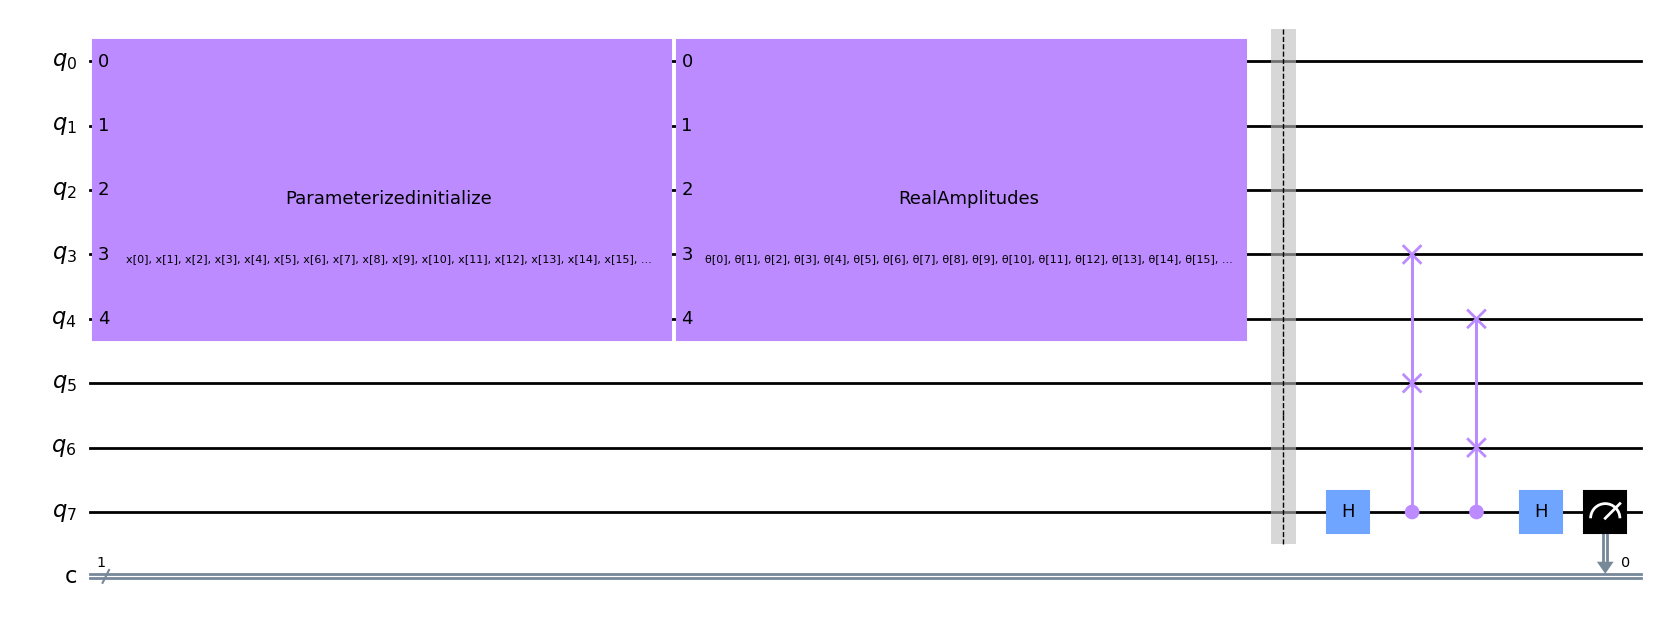

In [8]:
num_latent = 3
num_trash = 2

fm = RawFeatureVector(2 ** (num_latent + num_trash))

ae = auto_encoder_circuit(num_latent, num_trash)

qc = QuantumCircuit(num_latent + 2 * num_trash + 1, 1)
qc = qc.compose(fm, range(num_latent + num_trash))
qc = qc.compose(ae)

qc.draw(output="mpl", style="clifford")

In [9]:
def identity_interpret(x):
    return x


qnn = SamplerQNN(
    circuit=qc,
    input_params=fm.parameters,
    weight_params=ae.parameters,
    interpret=identity_interpret,
    output_shape=2,
)

In [10]:
def cost_func_digits(params_values):
    probabilities = qnn.forward(train_images, params_values)
    cost = np.sum(probabilities[:, 1]) / train_images.shape[0]

    # plotting part
    clear_output(wait=True)
    objective_func_vals.append(cost)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

    return cost

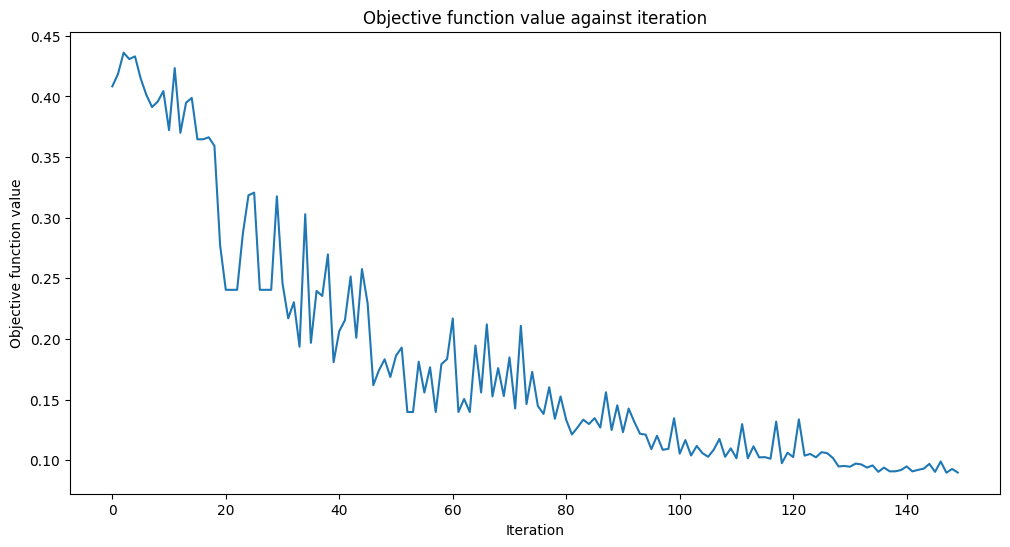

Fit in 22.23 seconds


In [23]:
import time

opt = COBYLA(maxiter=150)

objective_func_vals = []
# make the plot nicer
plt.rcParams["figure.figsize"] = (12, 6)

start = time.time()
opt_result = opt.minimize(
    fun=cost_func_digits, x0=np.random.random(30)
)  # x0 - initilize the model at a random 'location'
# because the inherent stochasticity with the (pseudo) random number (array in this case) generator, the model's performance will vary greatly
elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} seconds")

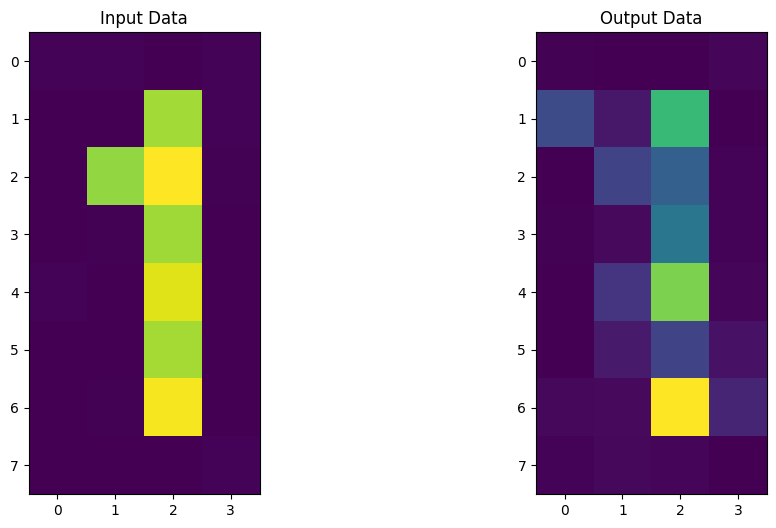

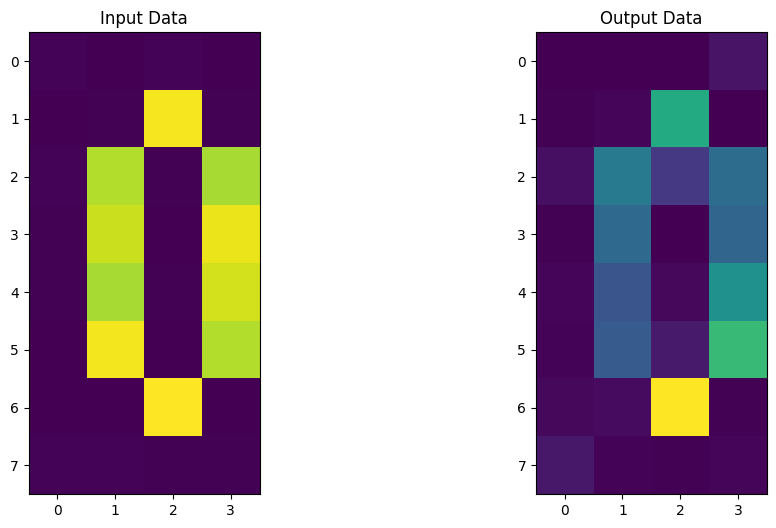

In [24]:
# Test
test_qc = QuantumCircuit(num_latent + num_trash)
test_qc = test_qc.compose(fm)
ansatz_qc = ansatz(num_latent + num_trash)
test_qc = test_qc.compose(ansatz_qc)
test_qc.barrier()
test_qc.reset(4)
test_qc.reset(3)
test_qc.barrier()
test_qc = test_qc.compose(ansatz_qc.inverse())

# sample new images
test_images, test_labels = get_dataset_digits(2, draw=False)
for image, label in zip(test_images, test_labels):
    original_qc = fm.assign_parameters(image)
    original_sv = Statevector(original_qc).data
    original_sv = np.reshape(np.abs(original_sv) ** 2, (8, 4))

    param_values = np.concatenate((image, opt_result.x))
    output_qc = test_qc.assign_parameters(param_values)
    output_sv = Statevector(output_qc).data
    output_sv = np.reshape(np.abs(output_sv) ** 2, (8, 4))

    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(original_sv)
    ax1.set_title("Input Data")
    ax2.imshow(output_sv)
    ax2.set_title("Output Data")
    plt.show()

In [27]:
train_images[0]

(32,)

In [48]:
np.pad(train_images[0], [2], mode="constant").reshape(6, 6).shape

(6, 6)

In [78]:
padded_train_images = torch.Tensor(
    np.array(
        [
            nn.functional.pad(torch.tensor(train_image), (1, 3)).reshape(6, 6).unsqueeze(0)
            for train_image in train_images
        ]
    )
)

In [79]:
padded_train_images.shape

torch.Size([10, 1, 6, 6])

In [173]:
mu, std = padded_train_images.mean(), padded_train_images.std()
padded_train_images.sub_(mu).div_(std)
padded_train_images_loader = DataLoader(dataset=padded_train_images, batch_size=4, shuffle=True)

In [174]:
class SmallAutoEncoder(nn.Module):
    def __init__(self, nb_channels: int, embedding_dim: int):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, nb_channels, kernel_size=3, padding=1),  # to 6x6
            nn.GELU(),
            nn.Conv2d(nb_channels, nb_channels, kernel_size=3, padding=1),  # to 6x6
            nn.GELU(),
            nn.Conv2d(nb_channels, nb_channels, kernel_size=3, padding=1),  # to 6x6
            nn.GELU(),
            nn.Conv2d(nb_channels, nb_channels, kernel_size=3),  # to 4x4
            nn.GELU(),
            nn.Conv2d(nb_channels, embedding_dim, kernel_size=4),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(embedding_dim, nb_channels, kernel_size=4),
            nn.GELU(),
            nn.ConvTranspose2d(nb_channels, nb_channels, kernel_size=3),  # from 4x4
            nn.GELU(),
            nn.ConvTranspose2d(nb_channels, nb_channels, kernel_size=1, stride=1),  # from 6x6
            nn.GELU(),
            nn.ConvTranspose2d(nb_channels, nb_channels, kernel_size=1, stride=1),  # from 6x6
            nn.GELU(),
            nn.ConvTranspose2d(nb_channels, 1, kernel_size=1, stride=1),  # from 6x6
        )

        # print the number of parameters
        print(f"number of parameters: {(sum(p.numel() for p in self.parameters())):,}")

    def encode(self, x):
        return self.encoder(x).view(x.size(0), -1)

    def decode(self, z):
        return self.decoder(z.view(z.size(0), -1, 1, 1))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class SmallAutoEncoderCBAM(nn.Module):
    def __init__(self, nb_channels: int, embedding_dim: int):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, nb_channels, kernel_size=3, padding=1),  # to 6x6
            CBAM(nb_channels, 1),
            nn.GELU(),
            nn.Conv2d(nb_channels, nb_channels, kernel_size=3, padding=1),  # to 6x6
            CBAM(nb_channels, 1),
            nn.GELU(),
            nn.Conv2d(nb_channels, nb_channels, kernel_size=3, padding=1),  # to 6x6
            CBAM(nb_channels, 1),
            nn.GELU(),
            nn.Conv2d(nb_channels, nb_channels, kernel_size=3),  # to 4x4
            CBAM(nb_channels, 1),
            nn.GELU(),
            nn.Conv2d(nb_channels, embedding_dim, kernel_size=4),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(embedding_dim, nb_channels, kernel_size=4),
            CBAM(nb_channels, 1),
            nn.GELU(),
            nn.ConvTranspose2d(nb_channels, nb_channels, kernel_size=3),  # from 4x4
            CBAM(nb_channels, 1),
            nn.GELU(),
            nn.ConvTranspose2d(nb_channels, nb_channels, kernel_size=1, stride=1),  # from 6x6
            CBAM(nb_channels, 1),
            nn.GELU(),
            nn.ConvTranspose2d(nb_channels, nb_channels, kernel_size=1, stride=1),  # from 6x6
            CBAM(nb_channels, 1),
            nn.GELU(),
            nn.ConvTranspose2d(nb_channels, 1, kernel_size=1, stride=1),  # from 6x6
        )

        # print the number of parameters
        print(f"number of parameters: {(sum(p.numel() for p in self.parameters())):,}")

    def encode(self, x):
        return self.encoder(x).view(x.size(0), -1)

    def decode(self, z):
        return self.decoder(z.view(z.size(0), -1, 1, 1))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [184]:
small_autoencoder = AutoEncoder(nb_channels=1, embedding_dim=5)
small_autoencoder = small_autoencoder.to(DEVICE)

number of parameters: 222


In [185]:
train_autoencoder(small_autoencoder, padded_train_images_loader, get_optimizer(small_autoencoder), nb_epochs=500)

100%|██████████| 3/3 [00:00<00:00, 128.25it/s]


Epoch 1, Loss: 82.4148


100%|██████████| 3/3 [00:00<00:00, 199.49it/s]


Epoch 2, Loss: 83.2874


100%|██████████| 3/3 [00:00<00:00, 278.59it/s]


Epoch 3, Loss: 82.9636


100%|██████████| 3/3 [00:00<00:00, 173.33it/s]


Epoch 4, Loss: 82.7544


100%|██████████| 3/3 [00:00<00:00, 199.63it/s]


Epoch 5, Loss: 81.4755


100%|██████████| 3/3 [00:00<00:00, 231.74it/s]


Epoch 6, Loss: 80.3640


100%|██████████| 3/3 [00:00<00:00, 252.77it/s]


Epoch 7, Loss: 81.7009


100%|██████████| 3/3 [00:00<00:00, 257.50it/s]


Epoch 8, Loss: 80.6161


100%|██████████| 3/3 [00:00<00:00, 282.23it/s]


Epoch 9, Loss: 80.3949


100%|██████████| 3/3 [00:00<00:00, 329.30it/s]


Epoch 10, Loss: 81.0741


100%|██████████| 3/3 [00:00<00:00, 285.17it/s]


Epoch 11, Loss: 81.0527


100%|██████████| 3/3 [00:00<00:00, 399.37it/s]


Epoch 12, Loss: 79.5504


100%|██████████| 3/3 [00:00<00:00, 162.17it/s]


Epoch 13, Loss: 78.4631


100%|██████████| 3/3 [00:00<00:00, 184.97it/s]


Epoch 14, Loss: 79.0420


100%|██████████| 3/3 [00:00<00:00, 299.19it/s]


Epoch 15, Loss: 77.9830


100%|██████████| 3/3 [00:00<00:00, 331.19it/s]


Epoch 16, Loss: 78.4815


100%|██████████| 3/3 [00:00<00:00, 333.68it/s]


Epoch 17, Loss: 78.4467


100%|██████████| 3/3 [00:00<00:00, 321.09it/s]


Epoch 18, Loss: 78.2413


100%|██████████| 3/3 [00:00<00:00, 378.08it/s]


Epoch 19, Loss: 77.6993


100%|██████████| 3/3 [00:00<00:00, 327.48it/s]


Epoch 20, Loss: 77.5794


100%|██████████| 3/3 [00:00<00:00, 448.33it/s]


Epoch 21, Loss: 77.0446


100%|██████████| 3/3 [00:00<00:00, 362.55it/s]


Epoch 22, Loss: 77.9733


100%|██████████| 3/3 [00:00<00:00, 327.91it/s]


Epoch 23, Loss: 75.8968


100%|██████████| 3/3 [00:00<00:00, 398.58it/s]


Epoch 24, Loss: 75.7742


100%|██████████| 3/3 [00:00<00:00, 372.31it/s]


Epoch 25, Loss: 77.1799


100%|██████████| 3/3 [00:00<00:00, 393.81it/s]


Epoch 26, Loss: 76.0046


100%|██████████| 3/3 [00:00<00:00, 319.09it/s]


Epoch 27, Loss: 75.6908


100%|██████████| 3/3 [00:00<00:00, 316.88it/s]


Epoch 28, Loss: 76.2060


100%|██████████| 3/3 [00:00<00:00, 383.29it/s]


Epoch 29, Loss: 75.4932


100%|██████████| 3/3 [00:00<00:00, 305.50it/s]


Epoch 30, Loss: 75.2977


100%|██████████| 3/3 [00:00<00:00, 360.24it/s]


Epoch 31, Loss: 74.6953


100%|██████████| 3/3 [00:00<00:00, 456.45it/s]


Epoch 32, Loss: 73.7799


100%|██████████| 3/3 [00:00<00:00, 319.77it/s]


Epoch 33, Loss: 74.2677


100%|██████████| 3/3 [00:00<00:00, 193.17it/s]


Epoch 34, Loss: 73.2760


100%|██████████| 3/3 [00:00<00:00, 425.39it/s]


Epoch 35, Loss: 74.0707


100%|██████████| 3/3 [00:00<00:00, 140.27it/s]


Epoch 36, Loss: 73.7847


100%|██████████| 3/3 [00:00<00:00, 134.30it/s]


Epoch 37, Loss: 73.5752


100%|██████████| 3/3 [00:00<00:00, 269.08it/s]


Epoch 38, Loss: 73.0737


100%|██████████| 3/3 [00:00<00:00, 367.44it/s]


Epoch 39, Loss: 73.2242


100%|██████████| 3/3 [00:00<00:00, 248.85it/s]


Epoch 40, Loss: 72.6580


100%|██████████| 3/3 [00:00<00:00, 282.36it/s]


Epoch 41, Loss: 72.5176


100%|██████████| 3/3 [00:00<00:00, 297.96it/s]


Epoch 42, Loss: 71.5959


100%|██████████| 3/3 [00:00<00:00, 278.30it/s]


Epoch 43, Loss: 72.3301


100%|██████████| 3/3 [00:00<00:00, 298.54it/s]


Epoch 44, Loss: 71.7823


100%|██████████| 3/3 [00:00<00:00, 297.06it/s]


Epoch 45, Loss: 70.7274


100%|██████████| 3/3 [00:00<00:00, 244.42it/s]


Epoch 46, Loss: 70.7570


100%|██████████| 3/3 [00:00<00:00, 271.29it/s]


Epoch 47, Loss: 71.3997


100%|██████████| 3/3 [00:00<00:00, 257.13it/s]


Epoch 48, Loss: 70.3356


100%|██████████| 3/3 [00:00<00:00, 222.51it/s]


Epoch 49, Loss: 70.1260


100%|██████████| 3/3 [00:00<00:00, 214.87it/s]


Epoch 50, Loss: 71.4720


100%|██████████| 3/3 [00:00<00:00, 105.20it/s]


Epoch 51, Loss: 69.5740


100%|██████████| 3/3 [00:00<00:00, 163.33it/s]


Epoch 52, Loss: 71.0530


100%|██████████| 3/3 [00:00<00:00, 265.12it/s]


Epoch 53, Loss: 69.9249


100%|██████████| 3/3 [00:00<00:00, 290.65it/s]


Epoch 54, Loss: 69.7810


100%|██████████| 3/3 [00:00<00:00, 304.91it/s]


Epoch 55, Loss: 69.6013


100%|██████████| 3/3 [00:00<00:00, 306.66it/s]


Epoch 56, Loss: 69.5305


100%|██████████| 3/3 [00:00<00:00, 281.67it/s]


Epoch 57, Loss: 69.0710


100%|██████████| 3/3 [00:00<00:00, 348.79it/s]


Epoch 58, Loss: 69.1323


100%|██████████| 3/3 [00:00<00:00, 377.68it/s]


Epoch 59, Loss: 68.7562


100%|██████████| 3/3 [00:00<00:00, 339.91it/s]


Epoch 60, Loss: 67.7859


100%|██████████| 3/3 [00:00<00:00, 270.18it/s]


Epoch 61, Loss: 67.5940


100%|██████████| 3/3 [00:00<00:00, 285.07it/s]


Epoch 62, Loss: 68.1411


100%|██████████| 3/3 [00:00<00:00, 184.29it/s]


Epoch 63, Loss: 68.0325


100%|██████████| 3/3 [00:00<00:00, 403.75it/s]


Epoch 64, Loss: 68.6536


100%|██████████| 3/3 [00:00<00:00, 402.64it/s]


Epoch 65, Loss: 67.7522


100%|██████████| 3/3 [00:00<00:00, 444.42it/s]


Epoch 66, Loss: 67.4494


100%|██████████| 3/3 [00:00<00:00, 356.84it/s]


Epoch 67, Loss: 67.4134


100%|██████████| 3/3 [00:00<00:00, 309.02it/s]


Epoch 68, Loss: 67.2524


100%|██████████| 3/3 [00:00<00:00, 306.88it/s]


Epoch 69, Loss: 66.8366


100%|██████████| 3/3 [00:00<00:00, 360.60it/s]


Epoch 70, Loss: 66.5849


100%|██████████| 3/3 [00:00<00:00, 420.93it/s]


Epoch 71, Loss: 65.7659


100%|██████████| 3/3 [00:00<00:00, 369.88it/s]


Epoch 72, Loss: 66.5752


100%|██████████| 3/3 [00:00<00:00, 354.70it/s]


Epoch 73, Loss: 66.3597


100%|██████████| 3/3 [00:00<00:00, 280.19it/s]


Epoch 74, Loss: 65.9175


100%|██████████| 3/3 [00:00<00:00, 205.12it/s]


Epoch 75, Loss: 65.8434


100%|██████████| 3/3 [00:00<00:00, 195.31it/s]


Epoch 76, Loss: 64.8495


100%|██████████| 3/3 [00:00<00:00, 298.67it/s]


Epoch 77, Loss: 65.6760


100%|██████████| 3/3 [00:00<00:00, 263.37it/s]


Epoch 78, Loss: 65.3791


100%|██████████| 3/3 [00:00<00:00, 328.79it/s]


Epoch 79, Loss: 65.8091


100%|██████████| 3/3 [00:00<00:00, 319.61it/s]


Epoch 80, Loss: 64.8504


100%|██████████| 3/3 [00:00<00:00, 397.02it/s]


Epoch 81, Loss: 64.8917


100%|██████████| 3/3 [00:00<00:00, 267.92it/s]


Epoch 82, Loss: 64.5298


100%|██████████| 3/3 [00:00<00:00, 275.34it/s]


Epoch 83, Loss: 64.4409


100%|██████████| 3/3 [00:00<00:00, 312.89it/s]


Epoch 84, Loss: 64.4762


100%|██████████| 3/3 [00:00<00:00, 302.76it/s]


Epoch 85, Loss: 64.3515


100%|██████████| 3/3 [00:00<00:00, 301.33it/s]


Epoch 86, Loss: 64.6562


100%|██████████| 3/3 [00:00<00:00, 232.34it/s]


Epoch 87, Loss: 63.8984


100%|██████████| 3/3 [00:00<00:00, 326.67it/s]


Epoch 88, Loss: 63.0967


100%|██████████| 3/3 [00:00<00:00, 336.22it/s]


Epoch 89, Loss: 63.6458


100%|██████████| 3/3 [00:00<00:00, 265.86it/s]


Epoch 90, Loss: 63.6026


100%|██████████| 3/3 [00:00<00:00, 359.07it/s]


Epoch 91, Loss: 63.4575


100%|██████████| 3/3 [00:00<00:00, 274.45it/s]


Epoch 92, Loss: 63.2845


100%|██████████| 3/3 [00:00<00:00, 267.40it/s]


Epoch 93, Loss: 62.9229


100%|██████████| 3/3 [00:00<00:00, 356.97it/s]


Epoch 94, Loss: 63.6224


100%|██████████| 3/3 [00:00<00:00, 328.29it/s]


Epoch 95, Loss: 62.1133


100%|██████████| 3/3 [00:00<00:00, 382.68it/s]


Epoch 96, Loss: 62.8089


100%|██████████| 3/3 [00:00<00:00, 318.21it/s]


Epoch 97, Loss: 63.2662


100%|██████████| 3/3 [00:00<00:00, 293.04it/s]


Epoch 98, Loss: 61.5741


100%|██████████| 3/3 [00:00<00:00, 316.78it/s]


Epoch 99, Loss: 61.5683


100%|██████████| 3/3 [00:00<00:00, 285.77it/s]


Epoch 100, Loss: 62.0047


100%|██████████| 3/3 [00:00<00:00, 283.14it/s]


Epoch 101, Loss: 62.6559


100%|██████████| 3/3 [00:00<00:00, 309.84it/s]


Epoch 102, Loss: 61.7152


100%|██████████| 3/3 [00:00<00:00, 282.08it/s]


Epoch 103, Loss: 61.0629


100%|██████████| 3/3 [00:00<00:00, 237.47it/s]


Epoch 104, Loss: 62.3004


100%|██████████| 3/3 [00:00<00:00, 244.20it/s]


Epoch 105, Loss: 61.2913


100%|██████████| 3/3 [00:00<00:00, 316.28it/s]


Epoch 106, Loss: 61.3995


100%|██████████| 3/3 [00:00<00:00, 313.02it/s]


Epoch 107, Loss: 61.0868


100%|██████████| 3/3 [00:00<00:00, 380.68it/s]


Epoch 108, Loss: 60.4040


100%|██████████| 3/3 [00:00<00:00, 295.01it/s]


Epoch 109, Loss: 60.9171


100%|██████████| 3/3 [00:00<00:00, 347.31it/s]


Epoch 110, Loss: 60.8002


100%|██████████| 3/3 [00:00<00:00, 335.67it/s]


Epoch 111, Loss: 60.6483


100%|██████████| 3/3 [00:00<00:00, 421.14it/s]


Epoch 112, Loss: 60.6024


100%|██████████| 3/3 [00:00<00:00, 342.35it/s]


Epoch 113, Loss: 60.2693


100%|██████████| 3/3 [00:00<00:00, 354.74it/s]


Epoch 114, Loss: 59.5928


100%|██████████| 3/3 [00:00<00:00, 385.56it/s]


Epoch 115, Loss: 59.5529


100%|██████████| 3/3 [00:00<00:00, 362.85it/s]


Epoch 116, Loss: 60.2780


100%|██████████| 3/3 [00:00<00:00, 358.16it/s]


Epoch 117, Loss: 60.7816


100%|██████████| 3/3 [00:00<00:00, 359.35it/s]


Epoch 118, Loss: 59.9478


100%|██████████| 3/3 [00:00<00:00, 406.49it/s]


Epoch 119, Loss: 59.6916


100%|██████████| 3/3 [00:00<00:00, 403.16it/s]


Epoch 120, Loss: 59.7396


100%|██████████| 3/3 [00:00<00:00, 384.25it/s]


Epoch 121, Loss: 60.1147


100%|██████████| 3/3 [00:00<00:00, 370.37it/s]


Epoch 122, Loss: 58.7347


100%|██████████| 3/3 [00:00<00:00, 343.94it/s]


Epoch 123, Loss: 58.7763


100%|██████████| 3/3 [00:00<00:00, 393.56it/s]


Epoch 124, Loss: 59.2388


100%|██████████| 3/3 [00:00<00:00, 352.36it/s]


Epoch 125, Loss: 59.0927


100%|██████████| 3/3 [00:00<00:00, 262.66it/s]


Epoch 126, Loss: 58.3741


100%|██████████| 3/3 [00:00<00:00, 320.89it/s]


Epoch 127, Loss: 58.2802


100%|██████████| 3/3 [00:00<00:00, 370.53it/s]


Epoch 128, Loss: 58.9282


100%|██████████| 3/3 [00:00<00:00, 426.11it/s]


Epoch 129, Loss: 58.0969


100%|██████████| 3/3 [00:00<00:00, 358.31it/s]


Epoch 130, Loss: 58.7397


100%|██████████| 3/3 [00:00<00:00, 372.00it/s]


Epoch 131, Loss: 58.7974


100%|██████████| 3/3 [00:00<00:00, 314.45it/s]


Epoch 132, Loss: 57.8834


100%|██████████| 3/3 [00:00<00:00, 356.65it/s]


Epoch 133, Loss: 59.2177


100%|██████████| 3/3 [00:00<00:00, 351.52it/s]


Epoch 134, Loss: 58.3657


100%|██████████| 3/3 [00:00<00:00, 368.35it/s]


Epoch 135, Loss: 58.2686


100%|██████████| 3/3 [00:00<00:00, 298.80it/s]


Epoch 136, Loss: 57.6075


100%|██████████| 3/3 [00:00<00:00, 354.36it/s]


Epoch 137, Loss: 58.0540


100%|██████████| 3/3 [00:00<00:00, 337.86it/s]


Epoch 138, Loss: 57.4304


100%|██████████| 3/3 [00:00<00:00, 402.94it/s]


Epoch 139, Loss: 57.9793


100%|██████████| 3/3 [00:00<00:00, 358.74it/s]


Epoch 140, Loss: 57.8505


100%|██████████| 3/3 [00:00<00:00, 235.77it/s]


Epoch 141, Loss: 57.8971


100%|██████████| 3/3 [00:00<00:00, 333.60it/s]


Epoch 142, Loss: 57.8153


100%|██████████| 3/3 [00:00<00:00, 400.36it/s]


Epoch 143, Loss: 57.5555


100%|██████████| 3/3 [00:00<00:00, 396.44it/s]


Epoch 144, Loss: 57.6549


100%|██████████| 3/3 [00:00<00:00, 364.65it/s]


Epoch 145, Loss: 58.1629


100%|██████████| 3/3 [00:00<00:00, 366.67it/s]


Epoch 146, Loss: 57.3186


100%|██████████| 3/3 [00:00<00:00, 434.57it/s]


Epoch 147, Loss: 57.3261


100%|██████████| 3/3 [00:00<00:00, 333.52it/s]


Epoch 148, Loss: 56.6003


100%|██████████| 3/3 [00:00<00:00, 211.30it/s]


Epoch 149, Loss: 57.1211


100%|██████████| 3/3 [00:00<00:00, 346.50it/s]


Epoch 150, Loss: 57.0913


100%|██████████| 3/3 [00:00<00:00, 360.78it/s]


Epoch 151, Loss: 56.9085


100%|██████████| 3/3 [00:00<00:00, 283.76it/s]


Epoch 152, Loss: 56.9137


100%|██████████| 3/3 [00:00<00:00, 327.77it/s]


Epoch 153, Loss: 56.2168


100%|██████████| 3/3 [00:00<00:00, 334.26it/s]


Epoch 154, Loss: 57.6323


100%|██████████| 3/3 [00:00<00:00, 398.84it/s]


Epoch 155, Loss: 57.5574


100%|██████████| 3/3 [00:00<00:00, 467.91it/s]


Epoch 156, Loss: 56.1091


100%|██████████| 3/3 [00:00<00:00, 460.09it/s]


Epoch 157, Loss: 56.5478


100%|██████████| 3/3 [00:00<00:00, 284.80it/s]


Epoch 158, Loss: 56.4445


100%|██████████| 3/3 [00:00<00:00, 400.70it/s]


Epoch 159, Loss: 56.5385


100%|██████████| 3/3 [00:00<00:00, 384.08it/s]


Epoch 160, Loss: 56.4582


100%|██████████| 3/3 [00:00<00:00, 376.23it/s]


Epoch 161, Loss: 55.5819


100%|██████████| 3/3 [00:00<00:00, 320.89it/s]


Epoch 162, Loss: 56.1202


100%|██████████| 3/3 [00:00<00:00, 407.45it/s]


Epoch 163, Loss: 56.0581


100%|██████████| 3/3 [00:00<00:00, 168.92it/s]


Epoch 164, Loss: 56.2084


100%|██████████| 3/3 [00:00<00:00, 126.33it/s]


Epoch 165, Loss: 55.8937


100%|██████████| 3/3 [00:00<00:00, 273.46it/s]


Epoch 166, Loss: 56.0793


100%|██████████| 3/3 [00:00<00:00, 297.48it/s]


Epoch 167, Loss: 56.4250


100%|██████████| 3/3 [00:00<00:00, 245.55it/s]


Epoch 168, Loss: 55.7607


100%|██████████| 3/3 [00:00<00:00, 365.27it/s]


Epoch 169, Loss: 55.1047


100%|██████████| 3/3 [00:00<00:00, 414.61it/s]


Epoch 170, Loss: 55.1273


100%|██████████| 3/3 [00:00<00:00, 350.96it/s]


Epoch 171, Loss: 55.1138


100%|██████████| 3/3 [00:00<00:00, 371.54it/s]


Epoch 172, Loss: 55.6663


100%|██████████| 3/3 [00:00<00:00, 280.79it/s]


Epoch 173, Loss: 56.1389


100%|██████████| 3/3 [00:00<00:00, 356.34it/s]


Epoch 174, Loss: 55.3837


100%|██████████| 3/3 [00:00<00:00, 350.26it/s]


Epoch 175, Loss: 56.0676


100%|██████████| 3/3 [00:00<00:00, 346.23it/s]


Epoch 176, Loss: 55.3249


100%|██████████| 3/3 [00:00<00:00, 325.05it/s]


Epoch 177, Loss: 55.2383


100%|██████████| 3/3 [00:00<00:00, 322.07it/s]


Epoch 178, Loss: 55.2088


100%|██████████| 3/3 [00:00<00:00, 354.56it/s]


Epoch 179, Loss: 54.6125


100%|██████████| 3/3 [00:00<00:00, 340.60it/s]


Epoch 180, Loss: 55.0073


100%|██████████| 3/3 [00:00<00:00, 391.33it/s]


Epoch 181, Loss: 54.9820


100%|██████████| 3/3 [00:00<00:00, 372.68it/s]


Epoch 182, Loss: 54.9211


100%|██████████| 3/3 [00:00<00:00, 319.46it/s]


Epoch 183, Loss: 54.9800


100%|██████████| 3/3 [00:00<00:00, 336.70it/s]


Epoch 184, Loss: 54.7173


100%|██████████| 3/3 [00:00<00:00, 334.03it/s]


Epoch 185, Loss: 54.7663


100%|██████████| 3/3 [00:00<00:00, 357.36it/s]


Epoch 186, Loss: 55.3655


100%|██████████| 3/3 [00:00<00:00, 344.36it/s]


Epoch 187, Loss: 54.7647


100%|██████████| 3/3 [00:00<00:00, 325.42it/s]


Epoch 188, Loss: 54.7045


100%|██████████| 3/3 [00:00<00:00, 364.11it/s]


Epoch 189, Loss: 53.9446


100%|██████████| 3/3 [00:00<00:00, 329.02it/s]


Epoch 190, Loss: 54.5987


100%|██████████| 3/3 [00:00<00:00, 386.19it/s]


Epoch 191, Loss: 54.5564


100%|██████████| 3/3 [00:00<00:00, 294.52it/s]


Epoch 192, Loss: 54.4599


100%|██████████| 3/3 [00:00<00:00, 365.10it/s]


Epoch 193, Loss: 53.7948


100%|██████████| 3/3 [00:00<00:00, 386.32it/s]


Epoch 194, Loss: 54.2306


100%|██████████| 3/3 [00:00<00:00, 326.69it/s]


Epoch 195, Loss: 54.2727


100%|██████████| 3/3 [00:00<00:00, 360.27it/s]


Epoch 196, Loss: 53.5917


100%|██████████| 3/3 [00:00<00:00, 345.31it/s]


Epoch 197, Loss: 53.9882


100%|██████████| 3/3 [00:00<00:00, 334.49it/s]


Epoch 198, Loss: 54.1092


100%|██████████| 3/3 [00:00<00:00, 347.56it/s]


Epoch 199, Loss: 54.0875


100%|██████████| 3/3 [00:00<00:00, 353.97it/s]


Epoch 200, Loss: 53.3401


100%|██████████| 3/3 [00:00<00:00, 305.22it/s]


Epoch 201, Loss: 53.7247


100%|██████████| 3/3 [00:00<00:00, 398.86it/s]


Epoch 202, Loss: 53.9397


100%|██████████| 3/3 [00:00<00:00, 375.97it/s]


Epoch 203, Loss: 53.8795


100%|██████████| 3/3 [00:00<00:00, 420.33it/s]


Epoch 204, Loss: 53.6259


100%|██████████| 3/3 [00:00<00:00, 379.06it/s]


Epoch 205, Loss: 53.0593


100%|██████████| 3/3 [00:00<00:00, 321.76it/s]


Epoch 206, Loss: 53.6757


100%|██████████| 3/3 [00:00<00:00, 302.73it/s]


Epoch 207, Loss: 52.8948


100%|██████████| 3/3 [00:00<00:00, 376.22it/s]


Epoch 208, Loss: 53.8671


100%|██████████| 3/3 [00:00<00:00, 254.98it/s]


Epoch 209, Loss: 53.3234


100%|██████████| 3/3 [00:00<00:00, 404.66it/s]


Epoch 210, Loss: 53.8653


100%|██████████| 3/3 [00:00<00:00, 314.67it/s]


Epoch 211, Loss: 53.7538


100%|██████████| 3/3 [00:00<00:00, 405.49it/s]


Epoch 212, Loss: 52.4982


100%|██████████| 3/3 [00:00<00:00, 353.30it/s]


Epoch 213, Loss: 52.3941


100%|██████████| 3/3 [00:00<00:00, 352.74it/s]


Epoch 214, Loss: 52.9607


100%|██████████| 3/3 [00:00<00:00, 384.70it/s]


Epoch 215, Loss: 52.8263


100%|██████████| 3/3 [00:00<00:00, 466.90it/s]


Epoch 216, Loss: 52.1120


100%|██████████| 3/3 [00:00<00:00, 325.31it/s]


Epoch 217, Loss: 52.5528


100%|██████████| 3/3 [00:00<00:00, 230.27it/s]


Epoch 218, Loss: 51.8916


100%|██████████| 3/3 [00:00<00:00, 381.14it/s]


Epoch 219, Loss: 53.1169


100%|██████████| 3/3 [00:00<00:00, 347.30it/s]


Epoch 220, Loss: 51.7361


100%|██████████| 3/3 [00:00<00:00, 415.36it/s]


Epoch 221, Loss: 53.1117


100%|██████████| 3/3 [00:00<00:00, 403.92it/s]


Epoch 222, Loss: 52.2912


100%|██████████| 3/3 [00:00<00:00, 330.81it/s]


Epoch 223, Loss: 51.4959


100%|██████████| 3/3 [00:00<00:00, 308.00it/s]


Epoch 224, Loss: 52.0603


100%|██████████| 3/3 [00:00<00:00, 352.49it/s]


Epoch 225, Loss: 52.0089


100%|██████████| 3/3 [00:00<00:00, 361.77it/s]


Epoch 226, Loss: 52.3944


100%|██████████| 3/3 [00:00<00:00, 330.07it/s]


Epoch 227, Loss: 51.0478


100%|██████████| 3/3 [00:00<00:00, 342.39it/s]


Epoch 228, Loss: 51.0265


100%|██████████| 3/3 [00:00<00:00, 325.40it/s]


Epoch 229, Loss: 52.0371


100%|██████████| 3/3 [00:00<00:00, 353.96it/s]


Epoch 230, Loss: 51.2656


100%|██████████| 3/3 [00:00<00:00, 395.38it/s]


Epoch 231, Loss: 50.6024


100%|██████████| 3/3 [00:00<00:00, 345.96it/s]


Epoch 232, Loss: 51.0985


100%|██████████| 3/3 [00:00<00:00, 393.08it/s]


Epoch 233, Loss: 50.9676


100%|██████████| 3/3 [00:00<00:00, 350.51it/s]


Epoch 234, Loss: 50.3592


100%|██████████| 3/3 [00:00<00:00, 334.04it/s]


Epoch 235, Loss: 51.5509


100%|██████████| 3/3 [00:00<00:00, 341.59it/s]


Epoch 236, Loss: 50.1555


100%|██████████| 3/3 [00:00<00:00, 288.91it/s]


Epoch 237, Loss: 51.2871


100%|██████████| 3/3 [00:00<00:00, 411.76it/s]


Epoch 238, Loss: 50.5280


100%|██████████| 3/3 [00:00<00:00, 399.32it/s]


Epoch 239, Loss: 50.4198


100%|██████████| 3/3 [00:00<00:00, 358.23it/s]


Epoch 240, Loss: 50.1580


100%|██████████| 3/3 [00:00<00:00, 350.14it/s]


Epoch 241, Loss: 50.0978


100%|██████████| 3/3 [00:00<00:00, 160.77it/s]


Epoch 242, Loss: 49.4051


100%|██████████| 3/3 [00:00<00:00, 226.90it/s]


Epoch 243, Loss: 49.8487


100%|██████████| 3/3 [00:00<00:00, 158.42it/s]


Epoch 244, Loss: 50.5193


100%|██████████| 3/3 [00:00<00:00, 328.71it/s]


Epoch 245, Loss: 48.9408


100%|██████████| 3/3 [00:00<00:00, 269.15it/s]


Epoch 246, Loss: 49.3795


100%|██████████| 3/3 [00:00<00:00, 363.17it/s]


Epoch 247, Loss: 48.7323


100%|██████████| 3/3 [00:00<00:00, 370.04it/s]


Epoch 248, Loss: 49.2467


100%|██████████| 3/3 [00:00<00:00, 328.61it/s]


Epoch 249, Loss: 49.2758


100%|██████████| 3/3 [00:00<00:00, 359.34it/s]


Epoch 250, Loss: 48.2762


100%|██████████| 3/3 [00:00<00:00, 403.27it/s]


Epoch 251, Loss: 48.1156


100%|██████████| 3/3 [00:00<00:00, 330.51it/s]


Epoch 252, Loss: 48.1181


100%|██████████| 3/3 [00:00<00:00, 329.34it/s]


Epoch 253, Loss: 48.5796


100%|██████████| 3/3 [00:00<00:00, 340.18it/s]


Epoch 254, Loss: 48.3453


100%|██████████| 3/3 [00:00<00:00, 408.35it/s]


Epoch 255, Loss: 48.2003


100%|██████████| 3/3 [00:00<00:00, 313.61it/s]


Epoch 256, Loss: 48.2456


100%|██████████| 3/3 [00:00<00:00, 324.27it/s]


Epoch 257, Loss: 48.6566


100%|██████████| 3/3 [00:00<00:00, 350.13it/s]


Epoch 258, Loss: 48.6389


100%|██████████| 3/3 [00:00<00:00, 343.95it/s]


Epoch 259, Loss: 47.6538


100%|██████████| 3/3 [00:00<00:00, 359.27it/s]


Epoch 260, Loss: 47.5443


100%|██████████| 3/3 [00:00<00:00, 414.17it/s]


Epoch 261, Loss: 48.1930


100%|██████████| 3/3 [00:00<00:00, 350.84it/s]


Epoch 262, Loss: 47.3137


100%|██████████| 3/3 [00:00<00:00, 173.98it/s]


Epoch 263, Loss: 47.8758


100%|██████████| 3/3 [00:00<00:00, 358.45it/s]


Epoch 264, Loss: 47.6204


100%|██████████| 3/3 [00:00<00:00, 370.21it/s]


Epoch 265, Loss: 46.9483


100%|██████████| 3/3 [00:00<00:00, 407.36it/s]


Epoch 266, Loss: 46.8024


100%|██████████| 3/3 [00:00<00:00, 370.62it/s]


Epoch 267, Loss: 46.4536


100%|██████████| 3/3 [00:00<00:00, 402.25it/s]


Epoch 268, Loss: 47.1511


100%|██████████| 3/3 [00:00<00:00, 366.87it/s]


Epoch 269, Loss: 46.2287


100%|██████████| 3/3 [00:00<00:00, 355.70it/s]


Epoch 270, Loss: 46.0422


100%|██████████| 3/3 [00:00<00:00, 393.61it/s]


Epoch 271, Loss: 45.2650


100%|██████████| 3/3 [00:00<00:00, 97.13it/s]


Epoch 272, Loss: 45.7553


100%|██████████| 3/3 [00:00<00:00, 165.58it/s]


Epoch 273, Loss: 45.7125


100%|██████████| 3/3 [00:00<00:00, 309.57it/s]


Epoch 274, Loss: 45.3326


100%|██████████| 3/3 [00:00<00:00, 279.33it/s]


Epoch 275, Loss: 45.2924


100%|██████████| 3/3 [00:00<00:00, 293.27it/s]


Epoch 276, Loss: 45.1704


100%|██████████| 3/3 [00:00<00:00, 310.80it/s]


Epoch 277, Loss: 44.9730


100%|██████████| 3/3 [00:00<00:00, 286.40it/s]


Epoch 278, Loss: 45.5783


100%|██████████| 3/3 [00:00<00:00, 382.96it/s]


Epoch 279, Loss: 44.7623


100%|██████████| 3/3 [00:00<00:00, 441.43it/s]


Epoch 280, Loss: 44.4383


100%|██████████| 3/3 [00:00<00:00, 340.97it/s]


Epoch 281, Loss: 43.5768


100%|██████████| 3/3 [00:00<00:00, 336.21it/s]


Epoch 282, Loss: 44.1498


100%|██████████| 3/3 [00:00<00:00, 346.93it/s]


Epoch 283, Loss: 44.0772


100%|██████████| 3/3 [00:00<00:00, 322.23it/s]


Epoch 284, Loss: 43.9575


100%|██████████| 3/3 [00:00<00:00, 386.65it/s]


Epoch 285, Loss: 43.6492


100%|██████████| 3/3 [00:00<00:00, 342.45it/s]


Epoch 286, Loss: 43.4342


100%|██████████| 3/3 [00:00<00:00, 399.17it/s]


Epoch 287, Loss: 43.9136


100%|██████████| 3/3 [00:00<00:00, 341.05it/s]


Epoch 288, Loss: 42.4044


100%|██████████| 3/3 [00:00<00:00, 180.53it/s]


Epoch 289, Loss: 42.2280


100%|██████████| 3/3 [00:00<00:00, 345.30it/s]


Epoch 290, Loss: 43.4075


100%|██████████| 3/3 [00:00<00:00, 447.65it/s]


Epoch 291, Loss: 42.6104


100%|██████████| 3/3 [00:00<00:00, 290.55it/s]


Epoch 292, Loss: 42.4440


100%|██████████| 3/3 [00:00<00:00, 346.42it/s]


Epoch 293, Loss: 42.3851


100%|██████████| 3/3 [00:00<00:00, 429.80it/s]


Epoch 294, Loss: 42.7144


100%|██████████| 3/3 [00:00<00:00, 353.70it/s]


Epoch 295, Loss: 41.9870


100%|██████████| 3/3 [00:00<00:00, 311.41it/s]


Epoch 296, Loss: 41.7234


100%|██████████| 3/3 [00:00<00:00, 321.71it/s]


Epoch 297, Loss: 40.9609


100%|██████████| 3/3 [00:00<00:00, 218.70it/s]


Epoch 298, Loss: 41.3897


100%|██████████| 3/3 [00:00<00:00, 130.45it/s]


Epoch 299, Loss: 41.9320


100%|██████████| 3/3 [00:00<00:00, 234.35it/s]


Epoch 300, Loss: 41.6929


100%|██████████| 3/3 [00:00<00:00, 303.26it/s]


Epoch 301, Loss: 40.8494


100%|██████████| 3/3 [00:00<00:00, 281.07it/s]


Epoch 302, Loss: 40.8166


100%|██████████| 3/3 [00:00<00:00, 345.37it/s]


Epoch 303, Loss: 40.5316


100%|██████████| 3/3 [00:00<00:00, 384.67it/s]


Epoch 304, Loss: 40.4057


100%|██████████| 3/3 [00:00<00:00, 379.63it/s]


Epoch 305, Loss: 40.3362


100%|██████████| 3/3 [00:00<00:00, 404.28it/s]


Epoch 306, Loss: 39.9813


100%|██████████| 3/3 [00:00<00:00, 345.68it/s]


Epoch 307, Loss: 39.8323


100%|██████████| 3/3 [00:00<00:00, 343.15it/s]


Epoch 308, Loss: 39.0789


100%|██████████| 3/3 [00:00<00:00, 296.38it/s]


Epoch 309, Loss: 40.2322


100%|██████████| 3/3 [00:00<00:00, 320.11it/s]


Epoch 310, Loss: 39.2669


100%|██████████| 3/3 [00:00<00:00, 347.81it/s]


Epoch 311, Loss: 38.5306


100%|██████████| 3/3 [00:00<00:00, 330.52it/s]


Epoch 312, Loss: 38.2809


100%|██████████| 3/3 [00:00<00:00, 196.53it/s]


Epoch 313, Loss: 38.1267


100%|██████████| 3/3 [00:00<00:00, 333.24it/s]


Epoch 314, Loss: 38.6385


100%|██████████| 3/3 [00:00<00:00, 301.39it/s]


Epoch 315, Loss: 39.1934


100%|██████████| 3/3 [00:00<00:00, 330.89it/s]


Epoch 316, Loss: 38.2838


100%|██████████| 3/3 [00:00<00:00, 343.81it/s]


Epoch 317, Loss: 38.7360


100%|██████████| 3/3 [00:00<00:00, 306.44it/s]


Epoch 318, Loss: 38.6660


100%|██████████| 3/3 [00:00<00:00, 307.73it/s]


Epoch 319, Loss: 37.1302


100%|██████████| 3/3 [00:00<00:00, 356.25it/s]


Epoch 320, Loss: 37.6674


100%|██████████| 3/3 [00:00<00:00, 296.48it/s]


Epoch 321, Loss: 38.0168


100%|██████████| 3/3 [00:00<00:00, 371.66it/s]


Epoch 322, Loss: 37.8282


100%|██████████| 3/3 [00:00<00:00, 334.97it/s]


Epoch 323, Loss: 37.6600


100%|██████████| 3/3 [00:00<00:00, 420.62it/s]


Epoch 324, Loss: 37.5756


100%|██████████| 3/3 [00:00<00:00, 354.50it/s]


Epoch 325, Loss: 37.4634


100%|██████████| 3/3 [00:00<00:00, 321.37it/s]


Epoch 326, Loss: 36.5948


100%|██████████| 3/3 [00:00<00:00, 325.41it/s]


Epoch 327, Loss: 36.3265


100%|██████████| 3/3 [00:00<00:00, 314.67it/s]


Epoch 328, Loss: 36.8973


100%|██████████| 3/3 [00:00<00:00, 408.92it/s]


Epoch 329, Loss: 35.4423


100%|██████████| 3/3 [00:00<00:00, 437.27it/s]


Epoch 330, Loss: 35.8996


100%|██████████| 3/3 [00:00<00:00, 361.89it/s]


Epoch 331, Loss: 35.2238


100%|██████████| 3/3 [00:00<00:00, 121.85it/s]


Epoch 332, Loss: 35.5692


100%|██████████| 3/3 [00:00<00:00, 331.84it/s]


Epoch 333, Loss: 35.5720


100%|██████████| 3/3 [00:00<00:00, 324.08it/s]


Epoch 334, Loss: 35.9318


100%|██████████| 3/3 [00:00<00:00, 316.76it/s]


Epoch 335, Loss: 35.9189


100%|██████████| 3/3 [00:00<00:00, 323.58it/s]


Epoch 336, Loss: 35.6857


100%|██████████| 3/3 [00:00<00:00, 356.22it/s]


Epoch 337, Loss: 34.9198


100%|██████████| 3/3 [00:00<00:00, 304.99it/s]


Epoch 338, Loss: 35.3200


100%|██████████| 3/3 [00:00<00:00, 330.85it/s]


Epoch 339, Loss: 34.5120


100%|██████████| 3/3 [00:00<00:00, 329.47it/s]


Epoch 340, Loss: 34.9455


100%|██████████| 3/3 [00:00<00:00, 311.61it/s]


Epoch 341, Loss: 33.7068


100%|██████████| 3/3 [00:00<00:00, 224.75it/s]


Epoch 342, Loss: 34.1140


100%|██████████| 3/3 [00:00<00:00, 351.03it/s]


Epoch 343, Loss: 33.2620


100%|██████████| 3/3 [00:00<00:00, 346.60it/s]


Epoch 344, Loss: 33.8991


100%|██████████| 3/3 [00:00<00:00, 314.03it/s]


Epoch 345, Loss: 33.6173


100%|██████████| 3/3 [00:00<00:00, 339.04it/s]


Epoch 346, Loss: 33.5455


100%|██████████| 3/3 [00:00<00:00, 345.90it/s]


Epoch 347, Loss: 33.3856


100%|██████████| 3/3 [00:00<00:00, 410.68it/s]


Epoch 348, Loss: 33.1374


100%|██████████| 3/3 [00:00<00:00, 301.98it/s]


Epoch 349, Loss: 33.2349


100%|██████████| 3/3 [00:00<00:00, 305.79it/s]


Epoch 350, Loss: 33.0488


100%|██████████| 3/3 [00:00<00:00, 256.72it/s]


Epoch 351, Loss: 32.8640


100%|██████████| 3/3 [00:00<00:00, 229.56it/s]


Epoch 352, Loss: 32.7937


100%|██████████| 3/3 [00:00<00:00, 200.31it/s]


Epoch 353, Loss: 32.5411


100%|██████████| 3/3 [00:00<00:00, 146.12it/s]


Epoch 354, Loss: 32.4617


100%|██████████| 3/3 [00:00<00:00, 241.72it/s]


Epoch 355, Loss: 32.2235


100%|██████████| 3/3 [00:00<00:00, 341.56it/s]


Epoch 356, Loss: 32.9440


100%|██████████| 3/3 [00:00<00:00, 234.79it/s]


Epoch 357, Loss: 31.4228


100%|██████████| 3/3 [00:00<00:00, 177.62it/s]


Epoch 358, Loss: 31.9582


100%|██████████| 3/3 [00:00<00:00, 330.23it/s]


Epoch 359, Loss: 31.8314


100%|██████████| 3/3 [00:00<00:00, 352.96it/s]


Epoch 360, Loss: 31.7647


100%|██████████| 3/3 [00:00<00:00, 340.44it/s]


Epoch 361, Loss: 31.0712


100%|██████████| 3/3 [00:00<00:00, 144.82it/s]


Epoch 362, Loss: 31.4570


100%|██████████| 3/3 [00:00<00:00, 253.72it/s]


Epoch 363, Loss: 31.3071


100%|██████████| 3/3 [00:00<00:00, 243.97it/s]


Epoch 364, Loss: 30.7124


100%|██████████| 3/3 [00:00<00:00, 367.33it/s]


Epoch 365, Loss: 31.8723


100%|██████████| 3/3 [00:00<00:00, 329.71it/s]


Epoch 366, Loss: 30.5552


100%|██████████| 3/3 [00:00<00:00, 334.64it/s]


Epoch 367, Loss: 31.0397


100%|██████████| 3/3 [00:00<00:00, 361.05it/s]


Epoch 368, Loss: 30.8855


100%|██████████| 3/3 [00:00<00:00, 425.83it/s]


Epoch 369, Loss: 30.8426


100%|██████████| 3/3 [00:00<00:00, 327.43it/s]


Epoch 370, Loss: 30.6501


100%|██████████| 3/3 [00:00<00:00, 308.79it/s]


Epoch 371, Loss: 30.5806


100%|██████████| 3/3 [00:00<00:00, 285.92it/s]


Epoch 372, Loss: 30.4556


100%|██████████| 3/3 [00:00<00:00, 342.91it/s]


Epoch 373, Loss: 30.8803


100%|██████████| 3/3 [00:00<00:00, 170.27it/s]


Epoch 374, Loss: 30.2879


100%|██████████| 3/3 [00:00<00:00, 317.69it/s]


Epoch 375, Loss: 30.0781


100%|██████████| 3/3 [00:00<00:00, 325.38it/s]


Epoch 376, Loss: 30.0501


100%|██████████| 3/3 [00:00<00:00, 302.03it/s]


Epoch 377, Loss: 29.9883


100%|██████████| 3/3 [00:00<00:00, 274.05it/s]


Epoch 378, Loss: 29.7824


100%|██████████| 3/3 [00:00<00:00, 249.47it/s]


Epoch 379, Loss: 29.8127


100%|██████████| 3/3 [00:00<00:00, 236.35it/s]


Epoch 380, Loss: 30.2137


100%|██████████| 3/3 [00:00<00:00, 341.69it/s]


Epoch 381, Loss: 30.2214


100%|██████████| 3/3 [00:00<00:00, 304.98it/s]


Epoch 382, Loss: 30.0676


100%|██████████| 3/3 [00:00<00:00, 368.43it/s]


Epoch 383, Loss: 30.0544


100%|██████████| 3/3 [00:00<00:00, 248.61it/s]


Epoch 384, Loss: 29.3838


100%|██████████| 3/3 [00:00<00:00, 230.60it/s]


Epoch 385, Loss: 29.8734


100%|██████████| 3/3 [00:00<00:00, 219.60it/s]


Epoch 386, Loss: 29.8420


100%|██████████| 3/3 [00:00<00:00, 260.37it/s]


Epoch 387, Loss: 28.6704


100%|██████████| 3/3 [00:00<00:00, 197.39it/s]


Epoch 388, Loss: 28.6547


100%|██████████| 3/3 [00:00<00:00, 217.29it/s]


Epoch 389, Loss: 28.9870


100%|██████████| 3/3 [00:00<00:00, 338.88it/s]


Epoch 390, Loss: 29.4869


100%|██████████| 3/3 [00:00<00:00, 231.35it/s]


Epoch 391, Loss: 28.7994


100%|██████████| 3/3 [00:00<00:00, 332.71it/s]


Epoch 392, Loss: 28.8510


100%|██████████| 3/3 [00:00<00:00, 292.66it/s]


Epoch 393, Loss: 28.7324


100%|██████████| 3/3 [00:00<00:00, 377.97it/s]


Epoch 394, Loss: 28.1051


100%|██████████| 3/3 [00:00<00:00, 280.44it/s]


Epoch 395, Loss: 28.5056


100%|██████████| 3/3 [00:00<00:00, 268.90it/s]


Epoch 396, Loss: 28.4404


100%|██████████| 3/3 [00:00<00:00, 326.46it/s]


Epoch 397, Loss: 29.0217


100%|██████████| 3/3 [00:00<00:00, 266.01it/s]


Epoch 398, Loss: 28.3816


100%|██████████| 3/3 [00:00<00:00, 248.21it/s]


Epoch 399, Loss: 28.9166


100%|██████████| 3/3 [00:00<00:00, 329.34it/s]


Epoch 400, Loss: 28.4030


100%|██████████| 3/3 [00:00<00:00, 269.59it/s]


Epoch 401, Loss: 28.1923


100%|██████████| 3/3 [00:00<00:00, 383.13it/s]


Epoch 402, Loss: 28.1320


100%|██████████| 3/3 [00:00<00:00, 222.71it/s]


Epoch 403, Loss: 28.6327


100%|██████████| 3/3 [00:00<00:00, 300.14it/s]


Epoch 404, Loss: 28.0927


100%|██████████| 3/3 [00:00<00:00, 266.40it/s]


Epoch 405, Loss: 27.5500


100%|██████████| 3/3 [00:00<00:00, 209.71it/s]


Epoch 406, Loss: 28.3895


100%|██████████| 3/3 [00:00<00:00, 173.13it/s]


Epoch 407, Loss: 27.8848


100%|██████████| 3/3 [00:00<00:00, 198.19it/s]


Epoch 408, Loss: 28.3531


100%|██████████| 3/3 [00:00<00:00, 268.38it/s]


Epoch 409, Loss: 27.7607


100%|██████████| 3/3 [00:00<00:00, 277.65it/s]


Epoch 410, Loss: 28.1278


100%|██████████| 3/3 [00:00<00:00, 241.60it/s]


Epoch 411, Loss: 27.3703


100%|██████████| 3/3 [00:00<00:00, 324.20it/s]


Epoch 412, Loss: 28.1466


100%|██████████| 3/3 [00:00<00:00, 322.51it/s]


Epoch 413, Loss: 28.1190


100%|██████████| 3/3 [00:00<00:00, 314.31it/s]


Epoch 414, Loss: 27.5531


100%|██████████| 3/3 [00:00<00:00, 313.48it/s]


Epoch 415, Loss: 27.5298


100%|██████████| 3/3 [00:00<00:00, 203.93it/s]


Epoch 416, Loss: 27.5189


100%|██████████| 3/3 [00:00<00:00, 346.24it/s]


Epoch 417, Loss: 27.0351


100%|██████████| 3/3 [00:00<00:00, 254.16it/s]


Epoch 418, Loss: 27.3549


100%|██████████| 3/3 [00:00<00:00, 245.37it/s]


Epoch 419, Loss: 27.3643


100%|██████████| 3/3 [00:00<00:00, 261.59it/s]


Epoch 420, Loss: 26.9696


100%|██████████| 3/3 [00:00<00:00, 291.95it/s]


Epoch 421, Loss: 27.7992


100%|██████████| 3/3 [00:00<00:00, 277.11it/s]


Epoch 422, Loss: 26.8169


100%|██████████| 3/3 [00:00<00:00, 293.82it/s]


Epoch 423, Loss: 27.3487


100%|██████████| 3/3 [00:00<00:00, 262.96it/s]


Epoch 424, Loss: 27.1873


100%|██████████| 3/3 [00:00<00:00, 364.37it/s]


Epoch 425, Loss: 27.1213


100%|██████████| 3/3 [00:00<00:00, 295.26it/s]


Epoch 426, Loss: 27.5583


100%|██████████| 3/3 [00:00<00:00, 223.51it/s]


Epoch 427, Loss: 26.9177


100%|██████████| 3/3 [00:00<00:00, 266.26it/s]


Epoch 428, Loss: 26.7011


100%|██████████| 3/3 [00:00<00:00, 233.95it/s]


Epoch 429, Loss: 26.9839


100%|██████████| 3/3 [00:00<00:00, 140.28it/s]


Epoch 430, Loss: 26.9503


100%|██████████| 3/3 [00:00<00:00, 177.62it/s]


Epoch 431, Loss: 26.8416


100%|██████████| 3/3 [00:00<00:00, 221.10it/s]


Epoch 432, Loss: 27.3791


100%|██████████| 3/3 [00:00<00:00, 352.97it/s]


Epoch 433, Loss: 27.3415


100%|██████████| 3/3 [00:00<00:00, 330.75it/s]


Epoch 434, Loss: 26.8270


100%|██████████| 3/3 [00:00<00:00, 383.92it/s]


Epoch 435, Loss: 27.1671


100%|██████████| 3/3 [00:00<00:00, 250.79it/s]


Epoch 436, Loss: 26.7371


100%|██████████| 3/3 [00:00<00:00, 253.48it/s]


Epoch 437, Loss: 26.4431


100%|██████████| 3/3 [00:00<00:00, 269.74it/s]


Epoch 438, Loss: 26.2341


100%|██████████| 3/3 [00:00<00:00, 316.92it/s]


Epoch 439, Loss: 27.1542


100%|██████████| 3/3 [00:00<00:00, 226.43it/s]


Epoch 440, Loss: 26.6827


100%|██████████| 3/3 [00:00<00:00, 364.46it/s]


Epoch 441, Loss: 26.6531


100%|██████████| 3/3 [00:00<00:00, 335.01it/s]


Epoch 442, Loss: 26.6001


100%|██████████| 3/3 [00:00<00:00, 392.75it/s]


Epoch 443, Loss: 26.6436


100%|██████████| 3/3 [00:00<00:00, 241.83it/s]


Epoch 444, Loss: 26.1833


100%|██████████| 3/3 [00:00<00:00, 225.09it/s]


Epoch 445, Loss: 26.8222


100%|██████████| 3/3 [00:00<00:00, 263.17it/s]


Epoch 446, Loss: 26.8008


100%|██████████| 3/3 [00:00<00:00, 208.97it/s]


Epoch 447, Loss: 26.3422


100%|██████████| 3/3 [00:00<00:00, 249.08it/s]


Epoch 448, Loss: 26.4633


100%|██████████| 3/3 [00:00<00:00, 186.02it/s]


Epoch 449, Loss: 26.7809


100%|██████████| 3/3 [00:00<00:00, 266.24it/s]


Epoch 450, Loss: 26.2694


100%|██████████| 3/3 [00:00<00:00, 247.34it/s]


Epoch 451, Loss: 26.3797


100%|██████████| 3/3 [00:00<00:00, 302.74it/s]


Epoch 452, Loss: 26.4158


100%|██████████| 3/3 [00:00<00:00, 320.03it/s]


Epoch 453, Loss: 26.3042


100%|██████████| 3/3 [00:00<00:00, 285.56it/s]


Epoch 454, Loss: 26.6520


100%|██████████| 3/3 [00:00<00:00, 364.24it/s]


Epoch 455, Loss: 26.7421


100%|██████████| 3/3 [00:00<00:00, 345.32it/s]


Epoch 456, Loss: 26.3198


100%|██████████| 3/3 [00:00<00:00, 326.55it/s]


Epoch 457, Loss: 26.2254


100%|██████████| 3/3 [00:00<00:00, 394.15it/s]


Epoch 458, Loss: 25.9679


100%|██████████| 3/3 [00:00<00:00, 321.95it/s]


Epoch 459, Loss: 25.9178


100%|██████████| 3/3 [00:00<00:00, 278.00it/s]


Epoch 460, Loss: 26.3687


100%|██████████| 3/3 [00:00<00:00, 334.09it/s]


Epoch 461, Loss: 26.1725


100%|██████████| 3/3 [00:00<00:00, 322.18it/s]


Epoch 462, Loss: 26.4618


100%|██████████| 3/3 [00:00<00:00, 254.11it/s]


Epoch 463, Loss: 26.6049


100%|██████████| 3/3 [00:00<00:00, 169.92it/s]


Epoch 464, Loss: 26.1460


100%|██████████| 3/3 [00:00<00:00, 130.54it/s]


Epoch 465, Loss: 25.7439


100%|██████████| 3/3 [00:00<00:00, 256.17it/s]


Epoch 466, Loss: 25.6507


100%|██████████| 3/3 [00:00<00:00, 189.22it/s]


Epoch 467, Loss: 25.8392


100%|██████████| 3/3 [00:00<00:00, 315.96it/s]


Epoch 468, Loss: 26.0776


100%|██████████| 3/3 [00:00<00:00, 365.65it/s]


Epoch 469, Loss: 26.1629


100%|██████████| 3/3 [00:00<00:00, 351.01it/s]


Epoch 470, Loss: 26.3384


100%|██████████| 3/3 [00:00<00:00, 353.99it/s]


Epoch 471, Loss: 26.0611


100%|██████████| 3/3 [00:00<00:00, 306.71it/s]


Epoch 472, Loss: 25.9115


100%|██████████| 3/3 [00:00<00:00, 338.82it/s]


Epoch 473, Loss: 26.0292


100%|██████████| 3/3 [00:00<00:00, 201.20it/s]


Epoch 474, Loss: 26.0124


100%|██████████| 3/3 [00:00<00:00, 368.01it/s]


Epoch 475, Loss: 26.2687


100%|██████████| 3/3 [00:00<00:00, 405.65it/s]


Epoch 476, Loss: 25.9578


100%|██████████| 3/3 [00:00<00:00, 343.36it/s]


Epoch 477, Loss: 25.9668


100%|██████████| 3/3 [00:00<00:00, 303.33it/s]


Epoch 478, Loss: 25.4686


100%|██████████| 3/3 [00:00<00:00, 341.36it/s]


Epoch 479, Loss: 26.0053


100%|██████████| 3/3 [00:00<00:00, 384.39it/s]


Epoch 480, Loss: 25.8595


100%|██████████| 3/3 [00:00<00:00, 377.41it/s]


Epoch 481, Loss: 25.4862


100%|██████████| 3/3 [00:00<00:00, 347.99it/s]


Epoch 482, Loss: 25.7383


100%|██████████| 3/3 [00:00<00:00, 411.48it/s]


Epoch 483, Loss: 25.8507


100%|██████████| 3/3 [00:00<00:00, 380.00it/s]


Epoch 484, Loss: 25.8375


100%|██████████| 3/3 [00:00<00:00, 352.39it/s]


Epoch 485, Loss: 25.4735


100%|██████████| 3/3 [00:00<00:00, 337.08it/s]


Epoch 486, Loss: 25.8199


100%|██████████| 3/3 [00:00<00:00, 328.91it/s]


Epoch 487, Loss: 25.6322


100%|██████████| 3/3 [00:00<00:00, 331.62it/s]


Epoch 488, Loss: 25.9304


100%|██████████| 3/3 [00:00<00:00, 309.34it/s]


Epoch 489, Loss: 25.8079


100%|██████████| 3/3 [00:00<00:00, 339.63it/s]


Epoch 490, Loss: 26.0079


100%|██████████| 3/3 [00:00<00:00, 318.41it/s]


Epoch 491, Loss: 25.5820


100%|██████████| 3/3 [00:00<00:00, 362.90it/s]


Epoch 492, Loss: 26.1529


100%|██████████| 3/3 [00:00<00:00, 302.05it/s]


Epoch 493, Loss: 25.4578


100%|██████████| 3/3 [00:00<00:00, 341.29it/s]


Epoch 494, Loss: 25.6626


100%|██████████| 3/3 [00:00<00:00, 352.19it/s]


Epoch 495, Loss: 25.9928


100%|██████████| 3/3 [00:00<00:00, 392.64it/s]


Epoch 496, Loss: 25.5926


100%|██████████| 3/3 [00:00<00:00, 346.46it/s]


Epoch 497, Loss: 25.6250


100%|██████████| 3/3 [00:00<00:00, 363.55it/s]


Epoch 498, Loss: 25.5868


100%|██████████| 3/3 [00:00<00:00, 338.53it/s]


Epoch 499, Loss: 25.6396


100%|██████████| 3/3 [00:00<00:00, 337.37it/s]

Epoch 500, Loss: 25.8631


In [188]:
input = padded_train_images[7].to(DEVICE)
z, output = get_encoded_decoded(small_autoencoder, input)

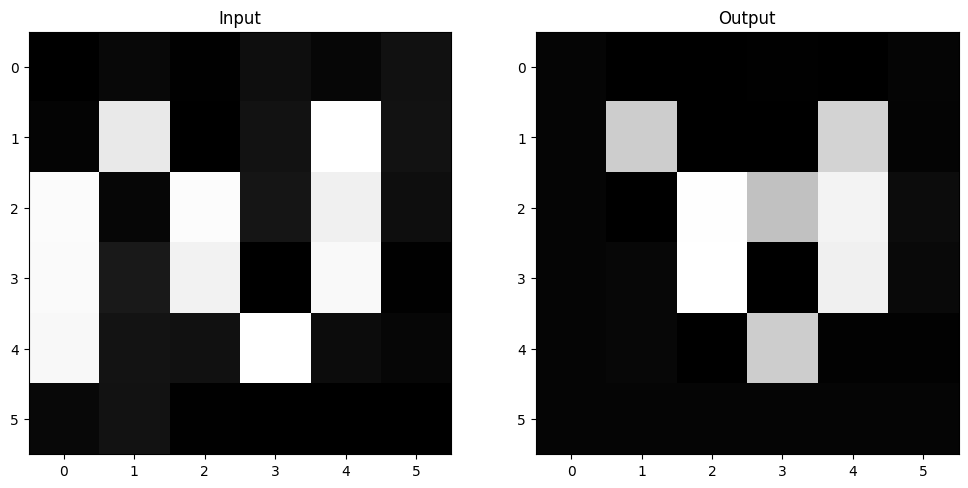

In [189]:
plot_imgs(input.cpu().detach().numpy().squeeze(), output.cpu().detach().numpy().squeeze())